In [1]:
from pydeeprecsys.rl.manager import MovieLensFairnessManager
from pydeeprecsys.rl.agents.rainbow import RainbowDQNAgent
from numpy.random import RandomState
from pydeeprecsys.rl.learning_statistics import LearningStatistics
import gym
from pydeeprecsys.rl.agents.agent import RandomAgent
manager = MovieLensFairnessManager()

In [2]:
random_state = RandomState(42)
rainbow_statistics = []
training_iterations = 20
training_episodes = 500

for i in range(training_iterations):
    stats = LearningStatistics()
    rainbow_agent = RainbowDQNAgent(
        25,
        manager.env.action_space.nvec[0],
        network_update_frequency=5,
        network_sync_frequency=250,
        batch_size=32,
        learning_rate=0.00025,
        discount_factor=0.9,
        buffer_size=10000,
        buffer_burn_in=32,
        random_state=random_state,
        statistics=stats
    )
    manager.train(rainbow_agent, max_episodes=training_episodes, statistics=stats)
    rainbow_statistics.append(stats)

Training...
Episode 499 Mean Rewards 35.22 		Training...
Episode 499 Mean Rewards 39.57 		Training...
Episode 499 Mean Rewards 38.10 		Training...
Episode 499 Mean Rewards 39.19 		Training...
Episode 499 Mean Rewards 39.75 		Training...
Episode 499 Mean Rewards 38.51 		Training...
Episode 499 Mean Rewards 39.40 		Training...
Episode 499 Mean Rewards 37.12 		Training...
Episode 499 Mean Rewards 40.07 		Training...
Episode 499 Mean Rewards 34.11 		Training...
Episode 499 Mean Rewards 32.12 		Training...
Episode 499 Mean Rewards 39.59 		Training...
Episode 499 Mean Rewards 39.19 		Training...
Episode 499 Mean Rewards 40.64 		Training...
Episode 499 Mean Rewards 40.69 		Training...
Episode 499 Mean Rewards 36.53 		Training...
Episode 499 Mean Rewards 38.14 		Training...
Episode 499 Mean Rewards 40.28 		Training...
Episode 499 Mean Rewards 38.13 		Training...
Episode 499 Mean Rewards 38.74 		

In [3]:
random_statistics = []
for i in range(training_iterations):
    stats = LearningStatistics()
    random_agent = RandomAgent(gym.spaces.Discrete(3883))
    manager.train(random_agent, max_episodes=training_episodes, statistics=stats)
    random_statistics.append(stats)

Training...
Episode 499 Mean Rewards 30.86 		Training...
Episode 499 Mean Rewards 33.61 		Training...
Episode 499 Mean Rewards 32.41 		Training...
Episode 499 Mean Rewards 32.70 		Training...
Episode 499 Mean Rewards 33.21 		Training...
Episode 499 Mean Rewards 32.63 		Training...
Episode 499 Mean Rewards 33.60 		Training...
Episode 499 Mean Rewards 34.49 		Training...
Episode 499 Mean Rewards 32.78 		Training...
Episode 499 Mean Rewards 30.69 		Training...
Episode 499 Mean Rewards 33.08 		Training...
Episode 499 Mean Rewards 31.73 		Training...
Episode 499 Mean Rewards 34.15 		Training...
Episode 499 Mean Rewards 32.03 		Training...
Episode 499 Mean Rewards 30.83 		Training...
Episode 499 Mean Rewards 31.94 		Training...
Episode 499 Mean Rewards 34.31 		Training...
Episode 499 Mean Rewards 31.82 		Training...
Episode 499 Mean Rewards 32.10 		Training...
Episode 499 Mean Rewards 30.21 		

In [4]:
import pandas
metrics = pandas.DataFrame()
for i in range(len(rainbow_statistics)):
    stats = pandas.DataFrame(rainbow_statistics[i].collected_metrics)
    stats['model'] = 'DuelingDQN'
    metrics = pandas.concat([metrics, stats])
for i in range(len(random_statistics)):
    stats = pandas.DataFrame(random_statistics[i].collected_metrics)
    stats['model'] = 'RandomAgent'
    metrics = pandas.concat([metrics, stats])

metrics.to_csv('all_metrics_test.csv')

# Plot Comparison

In [32]:
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
metrics = pandas.read_csv('all_metrics_test.csv', index_col=0)
metrics = metrics.query('metric=="moving_rewards"').reset_index(drop=True)
metrics['measurement'] = metrics.measurement.astype(float)

In [33]:
metrics

,metric,measurement,timestep,episode,model,env
0,moving_rewards,43.502459,50,0,DuelingDQN,NaN
1,moving_rewards,29.951229,50,1,DuelingDQN,NaN
2,moving_rewards,35.023108,50,2,DuelingDQN,NaN
3,moving_rewards,29.925622,50,3,DuelingDQN,NaN
4,moving_rewards,31.860498,50,4,DuelingDQN,NaN
...,...,...,...,...,...,...
19995,moving_rewards,30.019381,50,495,RandomAgent,NaN
19996,moving_rewards,30.253998,50,496,RandomAgent,NaN
19997,moving_rewards,30.022509,50,497,RandomAgent,NaN
19998,moving_rewards,30.183618,50,498,RandomAgent,NaN


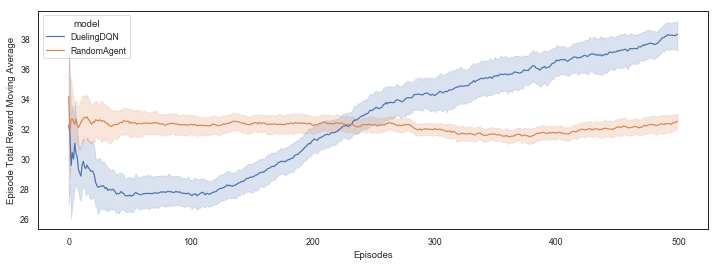

In [34]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_context("paper")
sns.set_style("white")
sns.color_palette("Set2")
plot = sns.lineplot(data=metrics, x="episode", y="measurement", hue='model', ci=95, legend='full')
plot.set(xlabel='Episodes', ylabel='Episode Total Reward Moving Average')
plt.savefig("preliminary_results.pdf")